# LIDC

# CNN - DenseNet 3D

In [1]:
import os
import pandas as pd
import numpy as np
import time
import random
import cv2
import pydicom
import SimpleITK as sitk

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import defaultdict


from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

from monai.transforms import (
    Compose, Resize, LoadImaged, RepeatChanneld, ScaleIntensity, ResizeWithPadOrCropd, ToTensord,
    RandGaussianNoised, RandAdjustContrastd, RandGaussianSmoothd, Rand3DElasticd, RandBiasFieldd, 
    RandCropByPosNegLabeld, Resized, RandFlipd, RandAffined, Compose, Resize
)

from monai.data import DataLoader, Dataset
from collections import Counter
from torchvision import models
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve


## Checking if Gpu were recognized

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is using GPU!")
    print(torch.cuda.get_device_name(0)) #prints the name of the GPU.
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU.")

PyTorch is using GPU!
NVIDIA GeForce RTX 3050 Ti Laptop GPU


# Constants

In [8]:
IMAGE_SIZE = 64
BATCH_SIZE = 1
NUM_CHANNELS = 1
DEPTH = 64
NUM_CLASSES = 2
PATIENCE_COUNTER = 5
EPOCHS = 50

DICOM_DIR = "/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm"
SAVE_DIR = "/home/vivianea/projects/BrainInnov/data/npy3d_split_data"

PATH_TRAIN = '/home/vivianea/projects/BrainInnov/data/npy3d_split/train'
PATH_TEST = '/home/vivianea/projects/BrainInnov/data/npy3d_split/test'
PATH_VAL = '/home/vivianea/projects/BrainInnov/data/npy3d_split/val'
PATH_MODEL = '/home/vivianea/projects/BrainInnov/models/best_model_EfficientNet.pth'
CSV_TRAIN = '/home/vivianea/projects/BrainInnov/data/npy3d_split/train_index.csv'
CSV_TEST = '/home/vivianea/projects/BrainInnov/data/npy3d_split/test_index.csv'
CSV_VAL = '/home/vivianea/projects/BrainInnov/data/npy3d_split/val_index.csv'
CLASS_MAP = {'cancer': 0, 'non-cancer': 1}
INDEX_TO_CLASS = {0: 'non-cancer', 1: 'cancer'}

AUG_PER_CLASS = {"train": 0, "val": 0, "test": 0}
SEED = 42
VAL_RATIO = 0.2
TEST_RATIO = 0.2
IMAGE_SIZE = (512, 512, 512)

# Preprocessing

In [4]:
os.makedirs(SAVE_DIR, exist_ok=True)

In [9]:
def is_dicom_segmentation(path):
    try:
        ds = pydicom.dcmread(path, stop_before_pixels=True)
        return hasattr(ds, "Modality") and ds.Modality == "SEG"
    except Exception:
        return False
    
def has_pixel_data(path):
    try:
        ds = pydicom.dcmread(path)
        return hasattr(ds, "pixel_array")
    except Exception:
        return False
    
def get_patient_id_from_filename(filename):
    # Assuming filename is like "LIDC-IDRI-0068_1-001.dcm"
    return filename.split("_")[0]  # Returns "LIDC-IDRI-0068"

In [17]:
def collect_by_patient(dicom_dir, save_dir):
    class_dict = defaultdict(lambda: defaultdict(list))
    log_file = os.path.join(save_dir, "bad_dicom_files.txt")
    skipped_patient_ids = set()

    with open(log_file, "w") as log:
        for cls in os.listdir(dicom_dir):
            cls_path = os.path.join(dicom_dir, cls)
            if not os.path.isdir(cls_path):
                continue

            for root, _, files in os.walk(cls_path):
                for fname in files:
                    if not fname.endswith(".dcm"):
                        continue

                    path = os.path.join(root, fname)

                    if is_dicom_segmentation(path):
                        log.write(f"Skipped segmentation file: {path}\n")
                        continue
                    if not has_pixel_data(path):
                        log.write(f"Missing pixel data: {path}\n")
                        continue

                    try:
                        pid = get_patient_id_from_filename(fname)
                        class_dict[cls][pid].append(path)
                    except Exception as e:
                        log.write(f"Bad DICOM: {path} | Error: {str(e)}\n")

        # Filter out patients with too few slices
        for cls in list(class_dict.keys()):
            for pid in list(class_dict[cls].keys()):
                if len(class_dict[cls][pid]) < 3:
                    log.write(f"Skipping patient {pid} (class: {cls}) — only {len(class_dict[cls][pid])} slices\n")
                    skipped_patient_ids.add(pid)
                    del class_dict[cls][pid]

    print(f"✅ Patient grouping complete.")
    print(f"🧠 Classes: {list(class_dict.keys())}")
    print(f"📦 Total patients: {sum(len(pids) for pids in class_dict.values())}")
    print(f"⚠️ Skipped patients with < 3 slices: {len(skipped_patient_ids)}")

    return class_dict

In [19]:
class_dict = collect_by_patient(DICOM_DIR, SAVE_DIR)

✅ Patient grouping complete.
🧠 Classes: ['non-cancer', 'cancer']
📦 Total patients: 157
⚠️ Skipped patients with < 3 slices: 0


In [21]:
def split_patient_ids(class_dict, test_ratio=0.2, val_ratio=0.1, seed=42):
    split_dict = {}

    for label, patient_ids in class_dict.items():
        patient_ids = list(patient_ids)
        total = len(patient_ids)
        print(f"\nLabel '{label}' has {total} patients")

        if total < 3:
            print(f"⚠️ Not enough patients to split '{label}' — assigning all to training.")
            split_dict[label] = {
                'train': patient_ids,
                'val': [],
                'test': []
            }
            continue

        try:
            # Split into train_val and test
            train_val_pids, test_pids = train_test_split(
                patient_ids,
                test_size=test_ratio,
                random_state=seed
            )
            print(f"  - After test split: train_val={len(train_val_pids)}, test={len(test_pids)}")

            # Split train_val into train and val
            val_ratio_adjusted = val_ratio / (1 - test_ratio)
            if len(train_val_pids) < 2:
                print(f"⚠️ Too few patients to further split train_val into train and val — skipping val split.")
                train_pids, val_pids = train_val_pids, []
            else:
                train_pids, val_pids = train_test_split(
                    train_val_pids,
                    test_size=val_ratio_adjusted,
                    random_state=seed
                )

            print(f"  - Final splits: train={len(train_pids)}, val={len(val_pids)}, test={len(test_pids)}")

            split_dict[label] = {
                'train': train_pids,
                'val': val_pids,
                'test': test_pids
            }

        except ValueError as e:
            print(f"❌ Split failed for label '{label}': {e}")
            print("Assigning all patients to training set.")
            split_dict[label] = {
                'train': patient_ids,
                'val': [],
                'test': []
            }

    return split_dict

In [23]:
splits = split_patient_ids(class_dict=class_dict, test_ratio=TEST_RATIO, val_ratio=VAL_RATIO, seed=SEED)


Label 'non-cancer' has 63 patients
  - After test split: train_val=50, test=13
  - Final splits: train=37, val=13, test=13

Label 'cancer' has 94 patients
  - After test split: train_val=75, test=19
  - Final splits: train=56, val=19, test=19


In [24]:
def resize_volume(volume, target_shape):
    resize = Resize(spatial_size=target_shape, mode="trilinear")
    resized = resize(volume)
    if isinstance(resized, np.ndarray):
        return resized
    elif hasattr(resized, "numpy"):
        return resized.numpy()
    else:
        return np.asarray(resized)

def normalize_volume(volume):
    volume = np.clip(volume, -1000, 400)
    min_val = np.min(volume)
    max_val = np.max(volume)
    if max_val - min_val > 0:
        volume = (volume - min_val) / (max_val - min_val)
    else:
        volume = np.zeros_like(volume)
    return volume.astype(np.float32)


In [25]:
def load_dicom_volume(paths, target_shape=IMAGE_SIZE):
    try:
        slices = []
        for path in paths:
            ds = pydicom.dcmread(path)
            if hasattr(ds, "InstanceNumber"):
                slices.append((ds.InstanceNumber, path))

        if len(slices) < 3:
            return None

        slices.sort(key=lambda x: x[0])
        sorted_paths = [p for _, p in slices]

        arrays = []
        with open(os.path.join(SAVE_DIR, "Slice_shape.txt"), "a") as f:
            for path in sorted_paths:
                img = sitk.ReadImage(path)
                arr = sitk.GetArrayFromImage(img)[0]  # Extract 2D slice
                expected_shape = (512, 512)
                if arr.shape == expected_shape:
                    shape_info = f"Slice shape from {path}: {arr.shape}"
                    f.write(shape_info + "\n")
                    arrays.append(arr)

        volume = np.stack(arrays, axis=0)  # (D, H, W)
        volume = np.transpose(volume, (1, 2, 0))  # (H, W, D)

        volume = normalize_volume(volume)
        
        volume = np.expand_dims(volume, axis = 0)  # Add channel for Resize
        volume = resize_volume(volume, target_shape)
        volume = volume[0]  # Remove channel dim
        
        return volume.astype(np.float32)
    except Exception as e:
        print(f"❌ load_dicom_volume error: {e}")
        return None

# Loading Dataset

In [ ]:
class NPYDataset3D(Dataset):
    def __init__(self, patient_dict, patient_ids, label_map, 
                 target_shape=(128,128,128), train=True):
        """
        patient_dict: dict[class][patient_id] = list_of_dicom_paths
        patient_ids: list of patient IDs for this split
        label_map: e.g., {'cancer':1, 'non-cancer':0}
        target_shape: desired volume shape after resize
        train: bool, apply augmentation only if True
        """
        self.patient_dict = patient_dict
        self.patient_ids = patient_ids
        self.label_map = label_map
        self.target_shape = target_shape
        self.train = train

        # Define augmentations for training
        self.transforms_train = Compose([
            RandFlipd(keys=["image"], spatial_axis=[0], prob=0.5),
            RandFlipd(keys=["image"], spatial_axis=[1], prob=0.5),
            RandFlipd(keys=["image"], spatial_axis=[2], prob=0.5),
            RandAffined(keys=["image"], 
                        rotate_range=(0.1, 0.1, 0.1),
                        shear_range=(0.05, 0.05, 0.05),
                        translate_range=(5,5,5),
                        scale_range=(0.1, 0.1, 0.1),
                        prob=0.3,
                        padding_mode='border'),
            RandBiasFieldd(keys=["image"], prob=0.3),
            RandGaussianNoised(keys=["image"], prob=0.3, mean=0.0, std=0.01),
            RandAdjustContrastd(keys=["image"], prob=0.3, gamma=(0.7, 1.5)),
            RandGaussianSmoothd(keys=["image"], prob=0.2,
                               sigma_x=(0.5, 1.0),
                               sigma_y=(0.5, 1.0),
                               sigma_z=(0.5, 1.0)),
        ])

        # No augmentation for validation/test
        self.transforms_eval = Compose([])

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        # Find class of this patient id
        for cls in self.patient_dict:
            if pid in self.patient_dict[cls]:
                dicom_paths = self.patient_dict[cls][pid]
                label = self.label_map[cls]
                break
        else:
            raise ValueError(f"Patient ID {pid} not found in dataset")

        volume = load_dicom_volume(dicom_paths, target_shape=self.target_shape)
        if volume is None:
            raise ValueError(f"Could not load volume for patient {pid}")

        volume = np.expand_dims(volume, axis=0)  # Add channel dim (C,H,W,D)

        # MONAI expects dict input for dictionary transforms
        sample = {"image": torch.tensor(volume)}

        if self.train:
            sample = self.transforms_train(sample)
        else:
            sample = self.transforms_eval(sample)

        image_tensor = sample["image"].float()
        label_tensor = torch.tensor(label).float()

        return image_tensor, label_tensor

In [5]:
train_dataset = NPYDataset3D(
    csv_path=CSV_TRAIN,
    npy_dir=PATH_TRAIN,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_dataset.class_to_idx

{0: 'non-cancer', 1: 'cancer'}

In [6]:
classes = [cls for cls in train_dataset.class_to_idx.values()]

In [7]:
len(train_dataset)

6588

In [8]:
train_dir = PATH_TRAIN
test_dir = PATH_TEST
val_dir = PATH_VAL

# Preprocessing

### Weighted Sampler

In [9]:
class_map = CLASS_MAP
labels_train = []
image_paths = []

for class_name in ['non-cancer', 'cancer']:
    folder = os.path.join(train_dir, class_name)
    for img_path in glob(os.path.join(folder, '*')):
        image_paths.append(img_path)
        labels_train.append(class_map[class_name])

In [10]:
class_map = CLASS_MAP
labels_test = []
image_paths = []

for class_name in ['non-cancer', 'cancer']:
    folder = os.path.join(test_dir, class_name)
    for img_path in glob(os.path.join(folder, '*')):
        image_paths.append(img_path)
        labels_test.append(class_map[class_name])

In [11]:
class_map = CLASS_MAP
labels_val = []
image_paths = []

for class_name in ['non-cancer', 'cancer']:
    folder = os.path.join(val_dir, class_name)
    for img_path in glob(os.path.join(folder, '*')):
        image_paths.append(img_path)
        labels_val.append(class_map[class_name])

In [12]:
class_map = CLASS_MAP
labels_val = []
image_paths = []

for class_name in ['non-cancer', 'cancer']:
    folder = os.path.join(val_dir, class_name)
    for img_path in glob(os.path.join(folder, '*')):
        image_paths.append(img_path)
        labels_val.append(class_map[class_name])

In [13]:
# Create the Weighted Sampler and DataLoader
# Compute class weights (0 = non-cancer, 1 = cancer)
class_counts = [labels_train.count(0), labels_train.count(1)]
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [weights[label] for label in labels_train]

sampler_train = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [14]:
# Create the Weighted Sampler and DataLoader
# Compute class weights (0 = non-cancer, 1 = cancer)
class_counts = [labels_test.count(0), labels_test.count(1)]
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [weights[label] for label in labels_test]
sampler_test = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [15]:
# Create the Weighted Sampler and DataLoader
# Compute class weights (0 = non-cancer, 1 = cancer)
class_counts = [labels_val.count(0), labels_val.count(1)]
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [weights[label] for label in labels_val]

sampler_val = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
transforms = Compose([
    ScaleIntensity(minv=0.0, maxv=1.0),
    Resize((DEPTH, IMAGE_SIZE, IMAGE_SIZE))
])

train_dataset = NPYDataset3D(
    csv_path=CSV_TRAIN,
    npy_dir=PATH_TRAIN,
    transform=transforms
)

test_dataset = NPYDataset3D(
    csv_path=CSV_TEST,
    npy_dir=PATH_TEST,
    transform=transforms
)

val_dataset = NPYDataset3D(
    csv_path=CSV_VAL,
    npy_dir=PATH_VAL,
    transform=transforms
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler_train)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=sampler_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=sampler_test)

### Size by classes in Train dataset

In [17]:
# Collect labels from your dataset
labels = [int(label) for _, label in train_dataset]

# Count occurrences
label_counts = Counter(labels)

# Define your index-to-class mapping manually if needed
index_to_class = INDEX_TO_CLASS  # adjust if different

# Print counts
print("\nTraining set counts:")
for idx, count in label_counts.items():
    print(f"Class: {index_to_class[idx]}, Count: {count}")


Training set counts:
Class: non-cancer, Count: 2623
Class: cancer, Count: 3965


# Architecture

In [18]:
from monai.networks.nets import DenseNet121

class DenseNet3DClassifier(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(DenseNet3DClassifier, self).__init__()
        self.model = DenseNet121(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=out_channels,
        )

    def forward(self, x):
        return self.model(x)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet3DClassifier(in_channels=1, out_channels=1)  # Binary classification
model = model.to(device)  # If using GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [20]:
for name, module in model.named_modules():
    print(name, ":", module)

 : DenseNet3DClassifier(
  (model): DenseNet121(
    (features): Sequential(
      (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (layers): Sequential(
            (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
       

In [21]:
summary(model, input_size=(BATCH_SIZE, NUM_CHANNELS, DEPTH, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                             Output Shape              Param #
DenseNet3DClassifier                               [1, 1]                    --
├─DenseNet121: 1-1                                 [1, 1]                    --
│    └─Sequential: 2-1                             [1, 1024, 2, 2, 2]        --
│    │    └─Conv3d: 3-1                            [1, 64, 32, 32, 32]       21,952
│    │    └─BatchNorm3d: 3-2                       [1, 64, 32, 32, 32]       128
│    │    └─ReLU: 3-3                              [1, 64, 32, 32, 32]       --
│    │    └─MaxPool3d: 3-4                         [1, 64, 16, 16, 16]       --
│    │    └─_DenseBlock: 3-5                       [1, 256, 16, 16, 16]      777,408
│    │    └─_Transition: 3-6                       [1, 128, 8, 8, 8]         33,280
│    │    └─_DenseBlock: 3-7                       [1, 512, 8, 8, 8]         1,804,416
│    │    └─_Transition: 3-8                       [1, 256, 4, 4, 4]         132,096
│    │   

# Trainning

In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, num_classes, patience, path_model):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Metrics
    confusion_matrix = MulticlassConfusionMatrix(num_classes=num_classes)
    precision = MulticlassPrecision(num_classes=num_classes, average='macro')
    recall = MulticlassRecall(num_classes=num_classes, average='macro')
    f1_score = MulticlassF1Score(num_classes=num_classes, average='macro')

    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = path_model

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # feed foward
            outputs = model(inputs)
            
            # Compute loss using cross entropy
            labels = labels.float().unsqueeze(1)  # shape [B] -> [B, 1]
            loss = criterion(outputs, labels)

            # backpropagation
            loss.backward()

            # Update weights
            optimizer.step()

            # Update results
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluation part to print metrics for each epoch
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                labels = labels.float().unsqueeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # _, preds = torch.max(outputs, 1)
                preds = (outputs > 0).long().squeeze(1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

                # For metrics
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        
        # all_preds = torch.cat(all_preds)
        # all_labels = torch.cat(all_labels)

        all_preds = torch.cat(all_preds).view(-1)
        all_labels = torch.cat(all_labels).view(-1)

        
        precision_value = precision(all_preds, all_labels)
        recall_value = recall(all_preds, all_labels)
        f1_value = f1_score(all_preds, all_labels)
        conf_matrix = confusion_matrix(all_preds, all_labels)

        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")
        print(f"Precision: {precision_value:.4f} | Recall: {recall_value:.4f} | F1 Score: {f1_value:.4f}\n")
        
        # --- Early Stopping Logic ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 # Reset patience counter
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'confusion_matrix': conf_matrix.cpu().numpy() # Save the confusion matrix of the best model
                }, best_model_path)
            print(f"Validation loss improved. Saving best model to {best_model_path}\n")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}\n")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {patience} consecutive epochs.\n")
            break # Exit the training loop

    print("\nTraining complete.")
    # Load the best model after training is complete (either by early stopping or max epochs)
    print(f"Loading best model from {best_model_path} for final metrics.")
    checkpoint = torch.load(best_model_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    # You might not need to load optimizer state if you're just doing inference or final evaluation
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    final_conf_matrix = checkpoint['confusion_matrix'] # Retrieve the confusion matrix of the best model

    return train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix

In [ ]:
t1 = time.time()
print(f"Using device: {device}")
train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS, num_classes=NUM_CLASSES, patience=PATIENCE_COUNTER, path_model=PATH_MODEL)

print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Using device: cuda
Epoch 1/50
Train Loss: 0.6719 | Train Acc: 49.86%
Val Loss: 0.8842 | Val Acc: 50.92%
Precision: 0.2546 | Recall: 0.5000 | F1 Score: 0.3374

Validation loss improved. Saving best model to /home/vivianea/projects/BrainInnov/models/best_model_EfficientNet.pth

Epoch 2/50
Train Loss: 0.5080 | Train Acc: 50.02%
Val Loss: 0.9696 | Val Acc: 49.57%
Precision: 0.4832 | Recall: 0.4867 | F1 Score: 0.4629

Validation loss did not improve. Patience: 1/5

Epoch 3/50
Train Loss: 0.2495 | Train Acc: 50.43%
Val Loss: 1.0350 | Val Acc: 45.03%
Precision: 0.4528 | Recall: 0.4535 | F1 Score: 0.4494

Validation loss did not improve. Patience: 2/5

Epoch 4/50
Train Loss: 0.1362 | Train Acc: 49.83%
Val Loss: 0.9625 | Val Acc: 50.63%
Precision: 0.5105 | Recall: 0.5092 | F1 Score: 0.4918

Validation loss did not improve. Patience: 3/5

Epoch 5/50
Train Loss: 0.0911 | Train Acc: 50.30%
Val Loss: 1.2800 | Val Acc: 45.61%
Precision: 0.4455 | Recall: 0.4517 | F1 Score: 0.4374

Validation loss did

# Evaluating

### Accuracy

In [ ]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)  # shape: [N, 1]
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = (probs > 0.5).long().squeeze()  # Threshold at 0.5, shape: [N]
        labels = labels.view(-1)  # Ensure shape match with predicted
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy on {total} images: {(correct / total) * 100:.2f}%')

Test Accuracy on 1334 images: 48.73%


### Loss and Accuracy

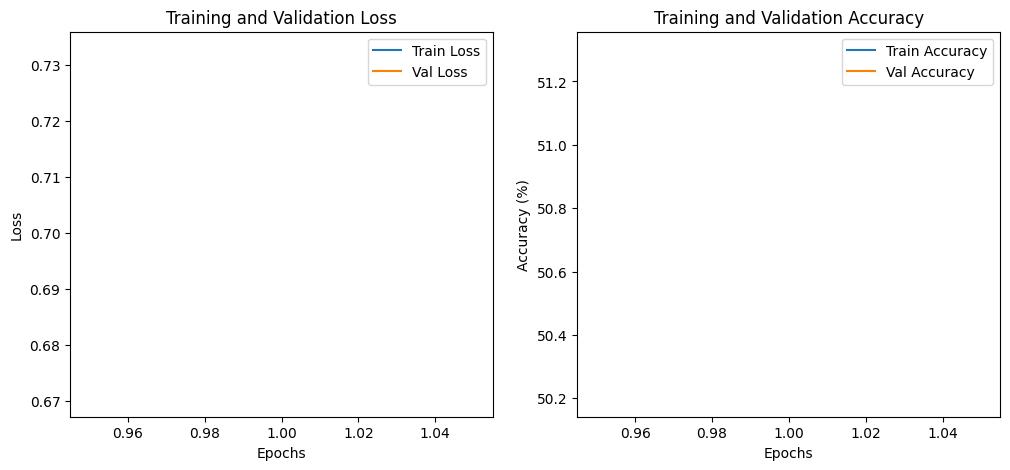

In [ ]:
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

### Confusion Matrix

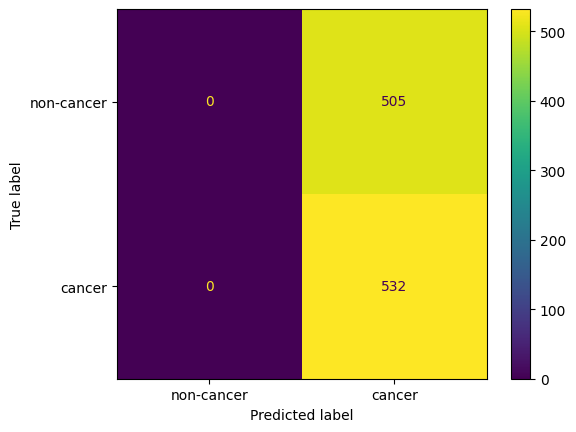

In [ ]:
cm = conf_matrix.cpu().numpy()
disp = ConfusionMatrixDisplay(cm, display_labels=classes,)
disp.plot()

### AUC and ROC Curve

In [ ]:
y_true = []
y_probs = []  # Collect probabilities for class 1 (cancer)

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:  # or test_loader
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # raw logits or softmax
        probs = torch.sigmoid(outputs)  # class 1 = cancer

        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

AUC: 0.4783


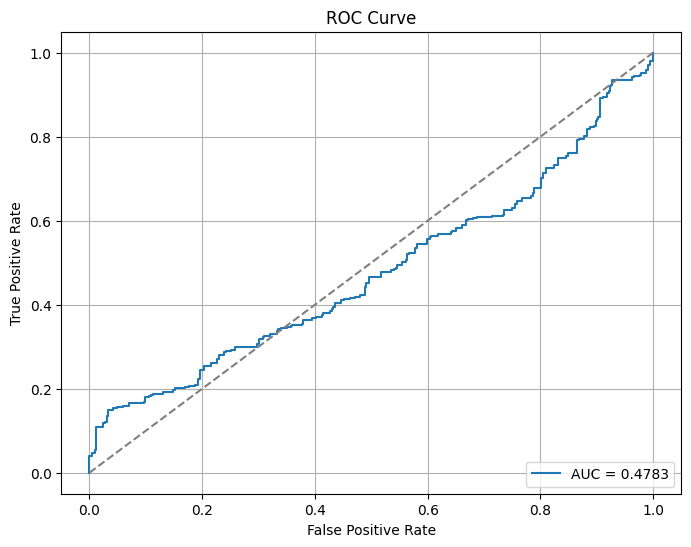

In [ ]:
# Compute AUC
auc = roc_auc_score(y_true, y_probs)
print(f"AUC: {auc:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Metrics

In [ ]:
precision = MulticlassPrecision(num_classes=NUM_CLASSES, average=None)
recall = MulticlassRecall(num_classes=NUM_CLASSES, average=None)
f1_score = MulticlassF1Score(num_classes=NUM_CLASSES, average=None)


all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())


all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)


per_class_precision = precision(all_preds, all_labels)
per_class_recall = recall(all_preds, all_labels)
per_class_f1 = f1_score(all_preds, all_labels)


for i, name in enumerate(classes):
    print(f"Class {i}-{name}: Precision: {per_class_precision[i]:.2f}, Recall: {per_class_recall[i]:.2f}, F1-Score: {per_class_f1[i]:.2f}")

Class 0-non-cancer: Precision: 0.49, Recall: 1.00, F1-Score: 0.65
Class 1-cancer: Precision: 0.00, Recall: 0.00, F1-Score: 0.00


In [ ]:
# Save Model

In [ ]:
torch.save(model.state_dict(), PATH_MODEL)

# GradCam

In [ ]:
def replace_relu_with_non_inplace(module):
    for name, child in module.named_children():
        if isinstance(child, torch.nn.ReLU) and child.inplace:
            setattr(module, name, torch.nn.ReLU(inplace=False))
        else:
            replace_relu_with_non_inplace(child)

replace_relu_with_non_inplace(model)

In [ ]:
import scipy.ndimage

class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            print("Backward hook triggered")
            self.gradients = grad_out[0].detach().clone()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        input_tensor = input_tensor.unsqueeze(0)  # Add batch dim if missing
        input_tensor = input_tensor.to(next(self.model.parameters()).device)
        input_tensor.requires_grad = True

        self.model.zero_grad()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output)

        loss = output[0, target_class]
        loss.backward()

        if self.gradients is None:
            raise RuntimeError("Backward hook did not capture gradients.")

        weights = torch.mean(self.gradients, dim=[2, 3, 4], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()

        return cam, target_class

    def visualize(self, image_tensor, cam):
    

        image_np = image_tensor.squeeze().cpu().numpy()
        cam_np = cam  # Already a NumPy array

        # Resize CAM to match input shape
        cam_resized = scipy.ndimage.zoom(
            cam_np,
            zoom=(
                image_np.shape[0] / cam_np.shape[0],
                image_np.shape[1] / cam_np.shape[1],
                image_np.shape[2] / cam_np.shape[2],
            ),
            order=1,
        )

        center = image_np.shape[0] // 2
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image_np[center], cmap='gray')
        ax[0].set_title("Original Slice")
        ax[1].imshow(image_np[center], cmap='gray')
        ax[1].imshow(cam_resized[center], cmap='jet', alpha=0.5)
        ax[1].set_title("Grad-CAM Overlay")
        plt.tight_layout()
        plt.show()

Backward hook triggered
Backward hook triggered
Backward hook triggered
Backward hook triggered
Backward hook triggered


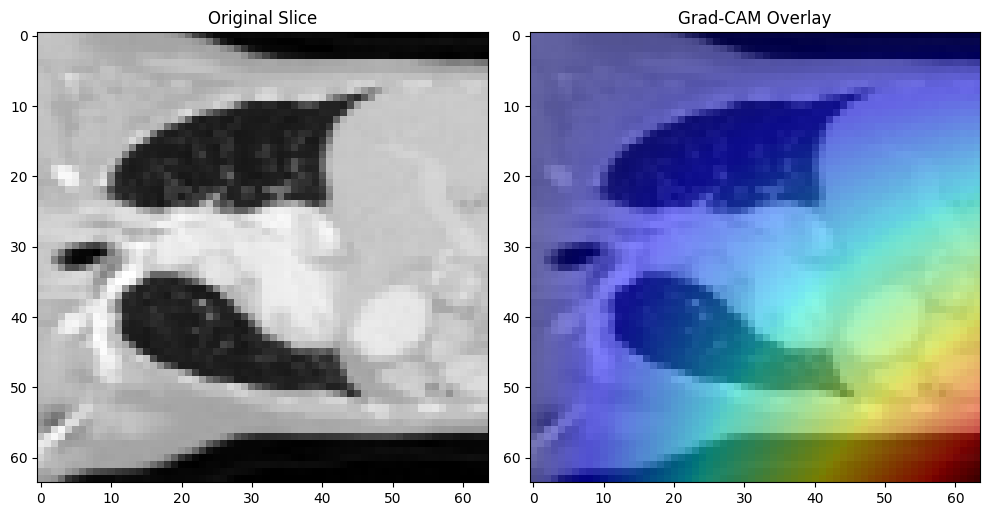

In [ ]:
# Choose target layer (last conv in Densenet 3D)
target_layer = model.model.features.norm5

# Initialize GradCAM
grad_cam = GradCAM3D(model, target_layer)

# Run on one sample
image, label = test_dataset[0]  # image should be a tensor
cam, predicted_class = grad_cam.generate(image)

# Show visualization
grad_cam.visualize(image, cam)